<a href="https://colab.research.google.com/github/ikhlas15/ATHENS-AI-Medical-Imaging/blob/main/H11_segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 11: Medical Image Segmentation with U-Net

### **Course**: Artificial Intelligence in Medical Imaging: From Fundamentals to Applications

***

## 1) Introduction

In medical imaging, segmentation means assigning a label to every pixel (2D) or voxel (3D). Typical tasks include delineating organs, lesions, or pathology (e.g., tumor contours in MRI, pneumothorax in chest X-ray, fluid in ultrasound). U-Net is the most widely used architecture for 2D medical image segmentation due to its encoder–decoder structure and skip connections, which combine semantic context with precise localization.

What you will learn
- Why U-Net is well-suited for medical segmentation
- How to implement a 2D U-Net in PyTorch
- Data handling for image–mask pairs (grayscale medical images)
- Loss functions: Dice, BCEWithLogits, and a combined loss
- Training, validation, and visualization of predictions

Prereqs
- 05_pytorch_primer: tensors, DataLoader, modules
- 06_training_loop_and_metrics: training loops, accuracy/metrics
- 10_cnn_blocks_and_advanced_architectures: encoders, skip connections

***

## 2) Setup and environment

Run this cell first in Colab to install and import dependencies.


In [ ]:
# Install packages (safe to re-run)
!pip install -q torch torchvision albumentations

import os
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

# Optional for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Device
device = torch.device("..." if torch.cuda.is_available() else "...")
print("Using device:", device)

Using device: cuda


Set a seed for reproducibility:


In [ ]:
 # TODO: choose your seed (hint: 42)
def set_seed(seed=____):
    import random

    # Python & NumPy seeds
    random.seed(____)        # TODO: seed
    np.random.seed(____)     # TODO: seed

    # PyTorch seeds
    torch.manual_seed(____)  # TODO: seed

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(____)   # TODO: seed

    # Ensure reproducibility
    torch.backends.cudnn.deterministic = ____   # TODO: True
    torch.backends.cudnn.benchmark = ____       # TODO: False

# Call the function
set_seed(____)    # TODO: seed (hint: 42)


***

## 3) U-Net architecture: overview

U-Net has:
- Encoder (down path): Convolution blocks + pooling to capture increasingly abstract features
- Bottleneck: deepest features
- Decoder (up path): Transposed conv upsampling + skip connections (concat with encoder features) to recover spatial detail
- Output head: 1×1 convolution to map to class logits (1 channel for binary segmentation)

Key design: Skip connections pass high-resolution features from encoder to decoder, critical for precise boundaries.

***

## 4) Implementing a 2D U-Net (from scratch)

We’ll code a compact, readable U-Net suitable for 1-channel medical images (e.g., X-ray, single MRI sequence). For multi-class, set n_classes>1.


In [ ]:
def double_conv(cin, cout):
    return nn.Sequential(
        # TODO: cin, cout
        nn.Conv2d(____, ____, 3, padding=1, bias=False),

        # TODO: cout
        nn.BatchNorm2d(____),


        nn.ReLU(inplace=True),
        # TODO: cout → cout
        nn.Conv2d(____, ____, 3, padding=1, bias=False),

        # TODO: cout
        nn.BatchNorm2d(____),


        nn.ReLU(inplace=True),
    )


class UNet(nn.Module):
    # TODO: default: in_channels=1, n_classes=1
    def __init__(self, in_channels=____, n_classes=____, features=(64,128,256,512)):

        super().__init__()

        f1, f2, f3, f4 = features   # encoder channel sizes

        # Encoder
        self.enc1 = double_conv(____, ____)   # TODO: in_channels → f1
        self.pool1 = nn.MaxPool2d(____)       # TODO: 2

        self.enc2 = double_conv(____, ____)   # TODO: f1 → f2
        self.pool2 = nn.MaxPool2d(____)

        self.enc3 = double_conv(____, ____)   # TODO: f2 → f3
        self.pool3 = nn.MaxPool2d(____)

        self.enc4 = double_conv(____, ____)   # TODO: f3 → f4
        self.pool4 = nn.MaxPool2d(____)

        # Bottleneck
        # TODO: f4 → f4*2
        self.bottleneck = double_conv(____, ____)


        # Decoder
        # TODO: f4*2 → f4
        self.up4  = nn.ConvTranspose2d(____, ____, 2, stride=2)

        # TODO: (f4 + f4) → f4
        self.dec4 = double_conv(____, ____)

        # TODO: f4 → f3
        self.up3  = nn.ConvTranspose2d(____, ____, 2, stride=2)

        # TODO: (f3 + f3) → f3
        self.dec3 = double_conv(____, ____)

        # TODO: f3 → f2
        self.up2  = nn.ConvTranspose2d(____, ____, 2, stride=2)
        # TODO: (f2 + f2) → f2
        self.dec2 = double_conv(____, ____)

        # TODO: f2 → f1
        self.up1  = nn.ConvTranspose2d(____, ____, 2, stride=2)

        # TODO: (f1 + f1) → f1
        self.dec1 = double_conv(____, ____)


        # Output head
        # TODO: f1 → n_classes
        self.head = nn.Conv2d(____, ____, kernel_size=1)


    def forward(self, x):

        # Encoder forward
        e1 = self.enc1(____)     # TODO: x
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with skip connections
        u4 = self.up4(b)
        # TODO: skip: e4
        d4 = self.dec4(torch.cat([u4, ____,], dim=1))


        u3 = self.up3(d4)
        # TODO: skip: e3
        d3 = self.dec3(torch.cat([u3, ____,], dim=1))


        u2 = self.up2(d3)
        # TODO: skip: e2
        d2 = self.dec2(torch.cat([u2, ____,], dim=1))


        u1 = self.up1(d2)
        # TODO: skip: e1
        d1 = self.dec1(torch.cat([u1, ____,], dim=1))


        # Output
        out = self.head(d1)
        return out


# Instantiate model
# TODO: 1, 1
model = UNet(in_channels=____, n_classes=____).to(device)


print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")


31.036481 M parameters


Notes:
- We return logits (unnormalized scores). For binary segmentation, apply sigmoid during loss or evaluation.
- Use padding=1 to keep spatial size consistent across double convs.

***

## 5) Dataset: image–mask pairs (medical)

For this notebook, we provide a template Dataset class assuming:
- Grayscale PNG/JPG images in images_dir
- Binary masks (same filename) in masks_dir
- Optional Albumentations for augmentation

You can prepare a small subset (e.g., pneumothorax masks, ultrasound BUSI masks) with paths set accordingly. If you don’t have a mask dataset yet, you can test the pipeline with synthetic masks (not clinically meaningful, but useful to validate code).


In [ ]:
from glob import glob   # finds all filenames in a folder
from PIL import Image   # used to read PNG/JPG images

class SegPairDataset(Dataset):   # TODO: create a custom PyTorch dataset
    def __init__(self, files, images_dir, masks_dir, transform=None, size_limit=None):
        # Construct full image paths
        # TODO: images_dir, p
        self.img_paths = [os.path.join(____, ____) for p in files]


        # Construct corresponding mask paths
        # TODO: masks_dir, ".jpg", ".tif"
        self.mask_paths = [
            os.path.join(____, os.path.basename(p).replace("____", "____")))
            for p in self.img_paths
        ]


        # Apply size limit if specified
        if size_limit is not None:
            self.img_paths = self.img_paths[:____]       # TODO: size_limit
            self.mask_paths = self.mask_paths[:____]     # TODO: size_limit

        # Store transform
        self.transform = ____

    # Length of dataset
    # TODO: number of images
    def __len__(self):
        return ____

    # Load single grayscale image
    # TODO: path, "L" for grayscale
    def _load_grayscale(self, path):
        img = Image.open(____).convert(____)
        return np.array(img)

    # Get single sample
    def __getitem__(self, idx):
        img  = self._load_grayscale(____)   # TODO: self.img_paths[idx]
        mask = self._load_grayscale(____)   # TODO: self.mask_paths[idx]

        # Normalize image to [0,1]
        img  = img.astype(np.float32)/____      # TODO: 255.0

        # Binary mask {0,1}
        mask = (mask > 0).astype(____)        # TODO: np.float32

        # Apply transform if any
        if self.transform:
            aug  = self.transform(image=img, mask=mask)
            img  = aug["____"]   # TODO: "image"
            mask = aug["____"]   # TODO: "mask"
        else:
            # Fallback: convert to PyTorch tensor
            img  = torch.from_numpy(img).unsqueeze(____).float()   # TODO: 0 → adds channel dimension
            mask = torch.from_numpy(mask).unsqueeze(____).float()  # TODO: 0

        return img, mask


Albumentations transform example (safe for many X-ray/ultrasound tasks):
- Avoid vertical flips (not anatomically plausible).
- Use small rotations, shifts, mild elastic transforms if clinically reasonable.

In [ ]:
# Training transforms
train_tf = A.Compose([
    # Horizontal flip
    A.HorizontalFlip(p=____),   # TODO: probability, hint: 0.5

    # Small rotation
    A.Rotate(limit=____, p=____),   # TODO: max rotation in degrees, prob (hint: 7, 0.5)

    # Brightness & contrast adjustment
    # TODO: brightness_limit, contrast_limit, prob (hint: 0.1, 0.1, 0.3)
    A.RandomBrightnessContrast(____, ____, p=____),


    # Shift, scale, rotate
    A.ShiftScaleRotate(
        shift_limit=____,     # TODO: max shift (hint: 0.02)
        scale_limit=____,     # TODO: max scale change (hint: 0.05)
        rotate_limit=____,    # TODO: max rotation (hint: 7)
        border_mode=____,     # TODO: 0 → constant padding
        p=____                # TODO: probability (hint: 0.3)
    ),

    # Normalize image
    A.Normalize(mean=(____,), std=(____,)),   # TODO: mean=0.5, std=0.5

    # Convert to tensor
    ToTensorV2(),
])


# Validation transforms
val_tf = A.Compose([
    # Only normalization
    A.Normalize(mean=(____,), std=(____,)),  # TODO: mean=0.5, std=0.5
    ToTensorV2(),
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Construct loaders (update paths):

In [ ]:
# First upload the zip file to Colab
!unzip -o /content/dataset_segmentation.zip

Archive:  /content/dataset_segmentation.zip
  inflating: dataset/masks/1060_IM-0042-1001.tif  
  inflating: dataset/masks/1045_IM-0036-1001.tif  
  inflating: dataset/masks/942_IM-2438-1001.tif  
  inflating: dataset/masks/107_IM-0049-1001.tif  
  inflating: dataset/masks/6_IM-2192-1001.tif  
  inflating: dataset/masks/1051_IM-0039-5001.tif  
  inflating: dataset/masks/23_IM-0879-1001.tif  
  inflating: dataset/masks/22_IM-0810-1001.tif  
  inflating: dataset/masks/1039_IM-0030-1002.tif  
  inflating: dataset/masks/960_IM-2451-4004.tif  
  inflating: dataset/masks/964_IM-2454-1001.tif  
  inflating: dataset/masks/996_IM-2479-1001.tif  
  inflating: dataset/masks/1090_IM-0062-1001.tif  
  inflating: dataset/masks/1036_IM-0029-1001.tif  
  inflating: dataset/masks/1067_IM-0048-1001.tif  
  inflating: dataset/masks/965_IM-2455-1001.tif  
  inflating: dataset/masks/941_IM-2438-1001.tif  
  inflating: dataset/masks/989_IM-2475-1002001.tif  
  inflating: dataset/masks/990_IM-2476-1001.tif  


In [ ]:
# Directories for images and masks
# TODO: path to images
images_dir = ____   # (hint: '/content/dataset/xrays/')
# TODO: path to masks
masks_dir  = ____   # (hint: '/content/dataset/masks/')

# Find all image files
 # TODO: pattern to match jpg files (hint: "./dataset/xrays/*.jpg")
files = glob(____)
# extract filenames only
files = [os.path.basename(f) for f in files]

# Split into training and validation sets
train_files, val_files, _, _ = train_test_split(
    ____, ____,               # TODO: input lists (hint: files, files)
    test_size=____,           # TODO: fraction for validation (hint: 0.2)
    random_state=____         # TODO: seed for reproducibility (hint: 42)
)


In [ ]:
# Augmentation factor for small medical datasets
augmentation_factor = ____   # TODO: multiply training files (hint: 10)

# Create training and validation datasets
train_ds = SegPairDataset(
    ____ * ____,         # TODO: tain_files * augmentation_factor
    ____ , ____ ,        # TODO: images_dir, masks_dir
    transform=____       # TODO: train_tf
)

val_ds = SegPairDataset(
    ____ , ____ ,        # TODO: val_files, images_dir, masks_dir
    transform=____       # TODO: val_tf
)

# Create DataLoaders
train_loader = DataLoader(
    ____ ,               # TODO: train_ds
    batch_size=____,     # TODO: 8
    shuffle=____,        # TODO: True
    num_workers=____,    # TODO: 2
    pin_memory=____      # TODO: True
)

val_loader = DataLoader(
    ____ ,               # TODO: val_ds
    batch_size=____,     # TODO: 8
    shuffle=____,        # TODO: False
    num_workers=____,    # TODO: 2
    pin_memory=____      # TODO: True
)


# Print dataset sizes
print("Train/Val sizes:", len(____), len(____))
# TODO: train_ds, val_ds


Train/Val sizes: 440 11


If you don’t have real masks yet, you can quickly generate toy circles/ellipses as masks to test the mechanics; just ensure to clearly mark them as synthetic.

***

## 6) Loss functions for segmentation

Dice captures overlap (shape). BCE penalizes per-pixel misclassification. A common practice is to combine both.


In [ ]:
# Dice coefficient
# TODO: small epsilon to avoid division by zero (hint: 1e-6)
def dice_coefficient(prob, truth, eps=____):
    # prob, truth: N x 1 x H x W; prob in [0,1], truth in {0,1}
    # TODO: sum over H, W → 2, 3
    inter = (prob * truth).sum(dim=(____, ____))
    # TODO: 2,3 for both prob and truth
    union = prob.sum(dim=(____, ____)) + truth.sum(dim=(____, ____))

    dice = (2*inter + eps) / (union + eps)
    return dice.mean()


# Dice loss
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets):
        # Convert logits → probability
        prob = torch.sigmoid(____)    # TODO: logits
        return 1.0 - dice_coefficient(____, ____)  # TODO: prob, targets


# BCE + Dice loss
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=____):   # TODO: 0.5
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_weight = ____

    def forward(self, logits, targets):
        return (
            self.bce_weight * self.bce(____, ____)  # TODO: logits, targets
            + (1 - self.bce_weight) * self.dice(____, ____)  # TODO: logits, targets
        )


# Instantiate criterion
criterion = BCEDiceLoss(bce_weight=____)  # TODO: 0.5


***

## 7) Training and validation loops

We’ll compute Dice on validation to monitor segmentation quality.


In [ ]:
# Train one epoch
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.____  # TODO: set model to training mode
    running_loss = ____

    for imgs, masks in loader:   # TODO: iterate over DataLoader
        # Move data to device
        # TODO: device, device
        imgs, masks = imgs.to(____), masks.to(____)

        # Clear gradients
        optimizer.____()   # TODO: zero_grad

        # Forward pass
        logits = model(____)   # TODO: imgs

        # Compute loss
        # TODO: unsqueeze(1) to match logits shape [B,1,H,W]
        loss = criterion(logits, masks.____(____))


        # Backward pass
        loss.____()   # TODO: backward
        optimizer.____()   # TODO: step

        # Accumulate running loss
        # TODO: 0 → multiply by batch size
        running_loss += loss.item() * imgs.size(____)


    # Return average loss per image
    return running_loss / len(____)   # TODO: loader.dataset


# Evaluate model
@torch.no_grad()
def evaluate(model, loader, criterion, device):
  # TODO: set model to eval mode
    model.____
    running_loss = 0.0
    running_dice = 0.0
    count = 0

    for imgs, masks in loader:
        imgs, masks = imgs.to(____), masks.to(____)  # TODO: device, device

        # Forward pass
        logits = model(____)   # TODO: imgs

        # Compute loss
        loss = criterion(logits, masks.____(____))   # TODO: unsqueeze(1)

        # Compute dice score
        prob = torch.sigmoid(____)   # TODO: logits
        # TODO: unsqueeze(1)
        dice = dice_coefficient(prob, masks.____(____)).item()


        # Accumulate metrics
        running_loss += loss.item() * imgs.size(____)  # TODO: 0 → batch size
        running_dice += dice * imgs.size(____)        # TODO: 0 → batch size
        count += imgs.size(____)                       # TODO: 0 → batch size

    # Return average loss and dice
    return running_loss / ____, running_dice / ____   # TODO: count, count


Train for a few epochs:

In [ ]:
# Instantiate model and optimizer
model = UNet(in_channels=____, n_classes=____).to(____)   # TODO: 1,1,device
optimizer = torch.optim.Adam(model.parameters(), lr=____)  # TODO: learning rate, hint: 1e-3

# Training parameters and history
num_epochs = ____        # TODO: number of epochs, hint: 10
train_losses, val_losses, val_dices = [], [], []

# Training loop
print("Starting training...")
for epoch in range(____, ____+1):   # TODO: 1, num_epochs
    # Train one epoch
    # TODO: model, train_loader, optimizer, criterion, device
    tr_loss = train_one_epoch(____, ____, ____, ____)
    # Evaluate on validation set
    # TODO: model, val_loader, criterion, device
    va_loss, va_dice = evaluate(____, ____, ____, ____)

    # Store metrics
    train_losses.append(____)   # TODO: tr_loss
    val_losses.append(____)     # TODO: va_loss
    val_dices.append(____)      # TODO: va_dice

    # Print epoch summary
    print(
        f"Epoch {epoch:02d}/{num_epochs} | "
        f"train_loss={____:.4f} | "   # TODO: tr_loss
        f"val_loss={____:.4f} | "     # TODO: va_loss
        f"val_dice={____:.4f}"         # TODO: va_dice
    )

print("Done.")


Starting training...
Epoch 01/10 | train_loss=0.3152 | val_loss=0.8572 | val_dice=0.4528
Epoch 02/10 | train_loss=0.1628 | val_loss=0.2688 | val_dice=0.7055
Epoch 03/10 | train_loss=0.1131 | val_loss=0.8583 | val_dice=0.1209
Epoch 04/10 | train_loss=0.0945 | val_loss=0.3792 | val_dice=0.6268
Epoch 05/10 | train_loss=0.0910 | val_loss=0.9968 | val_dice=0.1450
Epoch 06/10 | train_loss=0.0809 | val_loss=0.9646 | val_dice=0.0445
Epoch 07/10 | train_loss=0.0754 | val_loss=1.0075 | val_dice=0.0833
Epoch 08/10 | train_loss=0.0732 | val_loss=0.9530 | val_dice=0.3301
Epoch 09/10 | train_loss=0.0711 | val_loss=0.4526 | val_dice=0.4886
Epoch 10/10 | train_loss=0.0683 | val_loss=0.7084 | val_dice=0.2277
Done.


Plot curves:


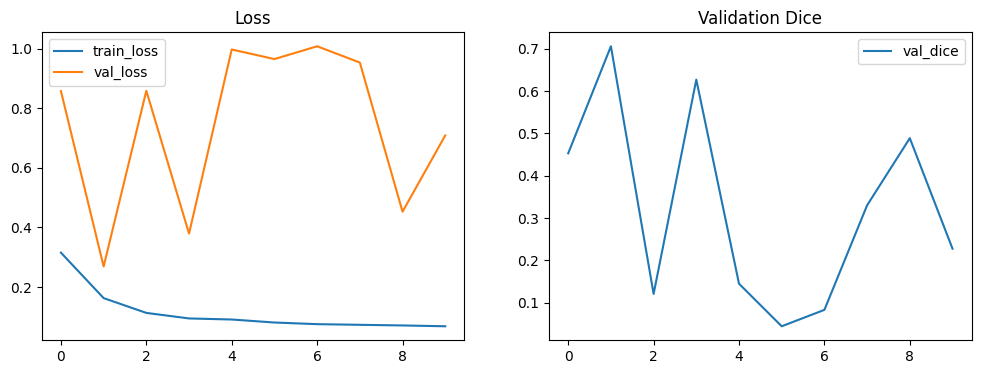

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss, and validation Dice
plt.figure(figsize=(____, ____))   # TODO: figure size (hint: 12, 4)

# Loss subplot
plt.subplot(____, ____, ____)      # TODO: 1, 2, 1
plt.plot(____, label="train_loss") # TODO: train_losses
plt.plot(____, label="val_loss")   # TODO: val_losses
plt.legend()
plt.title("____")                   # TODO: "Loss"

# Validation Dice subplot
plt.subplot(____, ____, ____)      # TODO: 1, 2, 2
plt.plot(____, label="val_dice")   # TODO: val_dices
plt.legend()
plt.title("____")                   # TODO: "Validation Dice"

plt.show()


***

## 8) Visualizing predictions

Pick a few validation samples, run inference, and visualize.

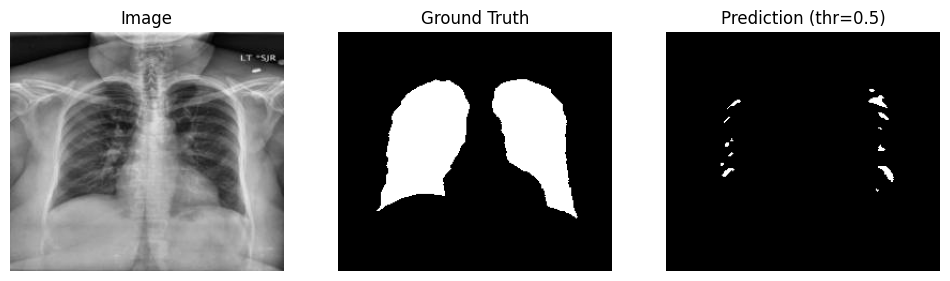

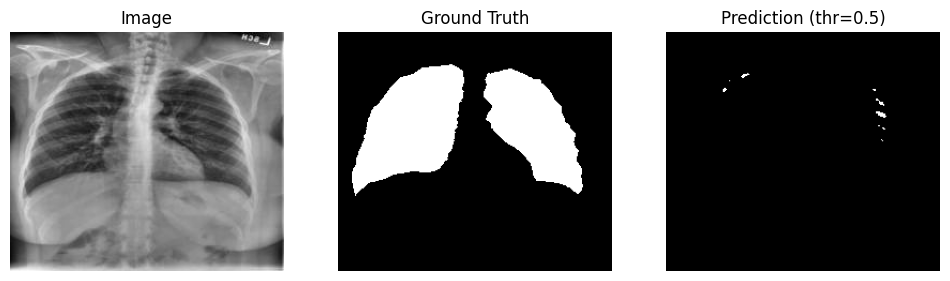

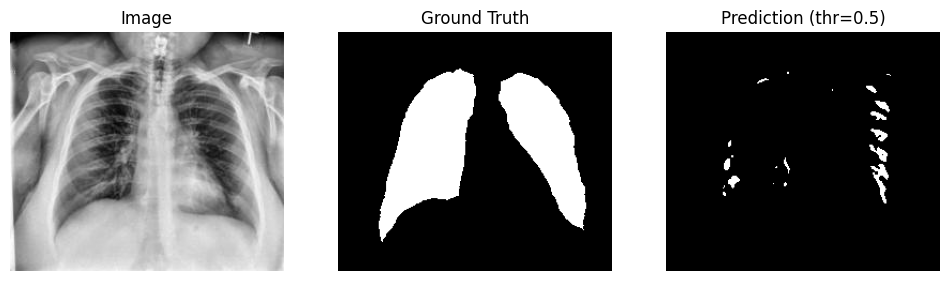

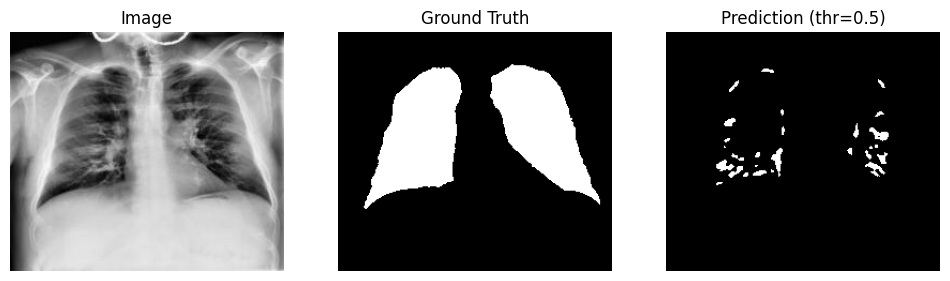

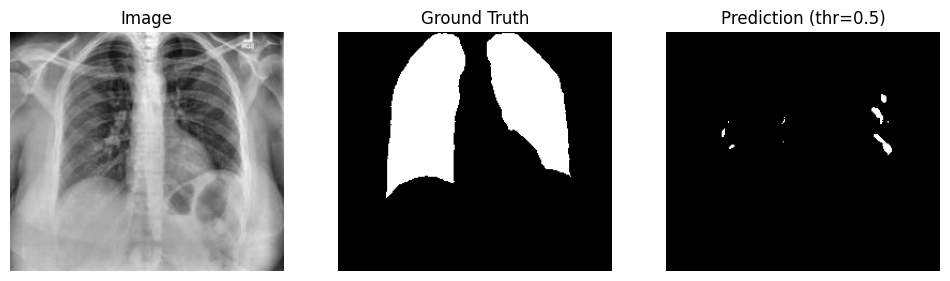

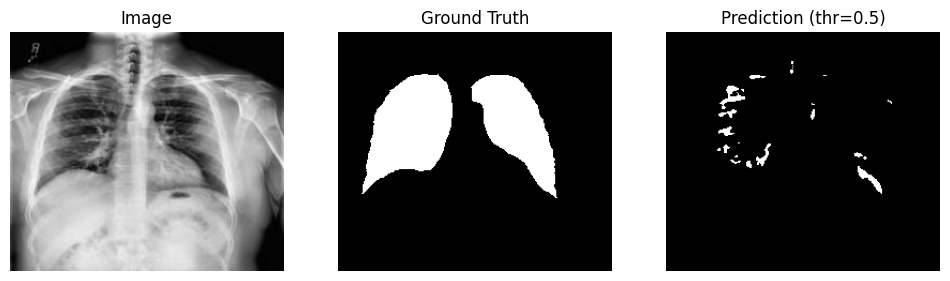

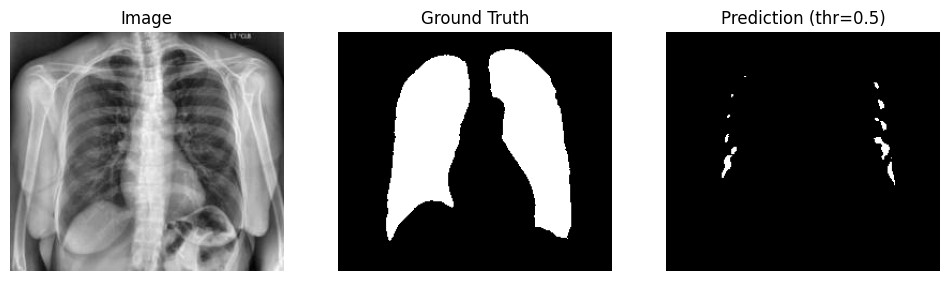

In [ ]:
@torch.no_grad()
 # TODO: default num_batches=1, threshold=0.5
def show_predictions(model, loader, device, num_batches=____, thr=____):

    model.____()   # TODO: set model to evaluation mode
    shown = 0

    for imgs, masks in loader:
        # Move images to device
        imgs = imgs.to(____)   # TODO: device

        # Forward pass
        logits = model(____)   # TODO: imgs
        prob = torch.sigmoid(____).cpu()  # TODO: logits
        masks = masks.____()             # TODO: move masks to cpu

        # visualize first min(4, batch_size)
        b = min(____, imgs.size(____))   # TODO: 4, 0

        for i in range(b):
            # TODO: 1, 3, 12, 4
            fig, ax = plt.subplots(____, ____, figsize=(____, ____))


            # Show image
            ax[0].imshow((imgs[i].cpu().squeeze().numpy()*____)+____, cmap="gray")
            # TODO: 0.5, 0.5 → undo normalization
            ax[0].set_title("____")  # TODO: "Image"

            # Show ground truth
            ax[1].imshow(masks[i].squeeze().numpy(), cmap="gray")
            ax[1].set_title("____")  # TODO: "Ground Truth"

            # Show prediction
            ax[2].imshow((prob[i] > ____).squeeze().numpy(), cmap="gray")  # TODO: thr
            ax[2].set_title(f"Prediction (thr={____})")  # TODO: thr

            # Remove axes
            for a in ax: a.____()  # TODO: axis('off')

            plt.show()

        shown += 1
        if shown >= ____:   # TODO: num_batches
            break

# Run prediction visualization
# TODO: 2, 0.5
show_predictions(model, val_loader, device, num_batches=____, thr=____)



Notes:
- For CT/MRI volumes (3D), U-Net 3D variants exist; or slice-wise 2D training with post-processing.
- For class imbalance (small lesions), consider focal loss or class-balanced sampling.
- Post-processing: largest connected component, hole filling, morphological ops help reduce false positives.

***

## 9) Practical tips for medical segmentation

- Preprocessing
  - X-ray: standardize intensity (e.g., normalize to , or mean–std). For CT, apply clinically relevant windowing before feed; for MRI, per-volume z-score normalization.
  - Resampling: ensure consistent pixel spacing across scans when training across heterogeneous sources.

- Augmentation
  - Keep it anatomically plausible. Horizontal flips are often okay for chest X-ray; avoid vertical flips.
  - Mild rotations, translations, elastic deformations can help if they reflect acquisition variability.

- Evaluation
  - Dice and IoU are common. Also report sensitivity and precision of the mask.
  - Stratify by region size: small lesions usually harder; report size-wise performance.
  - Visual error analysis is critical—review failure cases to improve data/augmentations.

- Inference
  - For large images, do sliding-window/tiling with overlap.
  - Test-time augmentation can slightly improve robustness.

***

## 10) Summary

You implemented and trained a 2D U-Net for medical image segmentation, learned how to structure datasets of image–mask pairs, chose appropriate losses (Dice and BCE), and visualized outputs. This forms the basis for most segmentation tasks in medical imaging.

Where to go next
- Use a public dataset (e.g., SIIM Pneumothorax, BUSI ultrasound) and plug its paths into the Dataset scaffold.
- Try different losses (Focal, Tversky), deeper backbones, or attention U-Nets.
- Move to advanced libraries (e.g., MONAI) that provide battle-tested medical imaging transforms and models.
- Extend to 3D U-Net for volumetric CT/MRI segmentation.

You now have a working, extensible U-Net pipeline you can adapt to your clinical problem of interest.